In [ ]:
%%writefile kaggle.json
{"username":"","key":""}

Writing kaggle.json


In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d 'potatohd404/bad-faces-60k-128x128'
!mkdir input
!unzip "bad-faces-60k-128x128" -d input

 99% 1.85G/1.87G [00:14<00:00, 118MB/s]
100% 1.87G/1.87G [00:14<00:00, 134MB/s]
Archive:  bad-faces-60k-128x128.zip
  inflating: input/gen_bad_faces.zip  


In [ ]:
!mkdir inputimgs
!unzip -P 2uCYCZGNkwJLYQ9t "/content/input/gen_bad_faces.zip" 

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: gen_bad_faces/47251.png  
  inflating: gen_bad_faces/18173.png  
 extracting: gen_bad_faces/56599.png  
  inflating: gen_bad_faces/46990.png  
  inflating: gen_bad_faces/30158.png  
 extracting: gen_bad_faces/2108.png  
  inflating: gen_bad_faces/10595.png  
  inflating: gen_bad_faces/59714.png  
  inflating: gen_bad_faces/17937.png  
  inflating: gen_bad_faces/42010.png  
  inflating: gen_bad_faces/19920.png  
  inflating: gen_bad_faces/37989.png  
  inflating: gen_bad_faces/7703.png  
  inflating: gen_bad_faces/24890.png  
  inflating: gen_bad_faces/16486.png  
  inflating: gen_bad_faces/43192.png  
 extracting: gen_bad_faces/33954.png  
  inflating: gen_bad_faces/26564.png  
  inflating: gen_bad_faces/16634.png  
 extracting: gen_bad_faces/58643.png  
  inflating: gen_bad_faces/54581.png  
  inflating: gen_bad_faces/21500.png  
  inflating: gen_bad_faces/14978.png  
  inflating: gen_bad_faces/31885.png 

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
np.random.seed(1)

## LOADING DATASET

images = []
for i in range(30000):
    dirname = '/content/gen_bad_faces/' + str(i+1) + '.png'
    img = cv2.imread(dirname)
    images.append(img)

images = np.array(images)

In [ ]:
images.shape

(30000, 128, 128, 3)

In [ ]:
train, valid, test = images[:20000,:], images[20000:25000,:], images[25000:,:]

In [ ]:
train = train / 255
valid = valid / 255
test = test / 255

In [ ]:
train.shape, test.shape, valid.shape

((20000, 128, 128, 3), (5000, 128, 128, 3), (5000, 128, 128, 3))

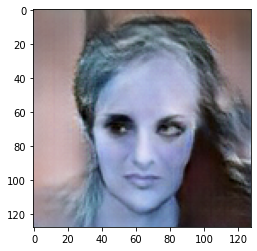

In [ ]:
plt.imshow(train[0])

In [ ]:
train[0]

array([[[0.53333333, 0.48627451, 0.47058824],
        [0.54509804, 0.48627451, 0.47058824],
        [0.56862745, 0.50588235, 0.48627451],
        ...,
        [0.40392157, 0.32941176, 0.29019608],
        [0.38431373, 0.31764706, 0.28235294],
        [0.34509804, 0.29803922, 0.25490196]],

       [[0.54509804, 0.47843137, 0.4627451 ],
        [0.55686275, 0.4745098 , 0.47058824],
        [0.56862745, 0.48627451, 0.47843137],
        ...,
        [0.40392157, 0.3254902 , 0.29019608],
        [0.40784314, 0.33333333, 0.29803922],
        [0.38039216, 0.32941176, 0.27843137]],

       [[0.55686275, 0.49019608, 0.48235294],
        [0.56862745, 0.49019608, 0.48627451],
        [0.56470588, 0.48235294, 0.48627451],
        ...,
        [0.41960784, 0.32941176, 0.29411765],
        [0.41568627, 0.34117647, 0.30196078],
        [0.40784314, 0.34901961, 0.29411765]],

       ...,

       [[0.55686275, 0.54901961, 0.62352941],
        [0.60784314, 0.57254902, 0.65882353],
        [0.6       , 0

In [ ]:
del images

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model


from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [ ]:
INPUT_DIM = (128,128,3) # Image dimension
BATCH_SIZE = 128
Z_DIM = 512 # Dimension of the latent vector (z)

In [ ]:
# ENCODER
def build_vae_encoder(input_dim, output_dim, conv_filters, conv_kernel_size,
                  conv_strides, use_batch_norm = False, use_dropout = False):
 
  global K
  K.clear_session()
 
  n_layers = len(conv_filters)
 
  encoder_input = Input(shape = input_dim, name = 'encoder_input')
  x = encoder_input
 
  for i in range(n_layers):
      x = Conv2D(filters = conv_filters[i],
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i],
                  padding = 'same',
                  name = 'encoder_conv_' + str(i)
                  )(x)
      if use_batch_norm:
        x = BathcNormalization()(x)
 
      x = LeakyReLU()(x)
 
      if use_dropout:
        x = Dropout(rate=0.25)(x)
 
  shape_before_flattening = K.int_shape(x)[1:] 
 
  x = Flatten()(x)
 
  mean_mu = Dense(output_dim, name = 'mu')(x)
  log_var = Dense(output_dim, name = 'log_var')(x)
 
  def sampling(args):
    mean_mu, log_var = args
    epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.)
    return mean_mu + K.exp(log_var/2)*epsilon   
 
  encoder_output = Lambda(sampling, name='encoder_output')([mean_mu, log_var])
 
  return encoder_input, encoder_output, mean_mu, log_var, shape_before_flattening, Model(encoder_input, encoder_output)
 
vae_encoder_input, vae_encoder_output,  mean_mu, log_var, vae_shape_before_flattening, vae_encoder  = build_vae_encoder(input_dim = INPUT_DIM,
                                    output_dim = Z_DIM,
                                    conv_filters = [32, 64, 64, 64],
                                    conv_kernel_size = [3,3,3,3],
                                    conv_strides = [2,2,2,2])

In [ ]:
def build_decoder(input_dim, shape_before_flattening, conv_filters, conv_kernel_size, 
                  conv_strides):

  n_layers = len(conv_filters)

  decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')

  x = Dense(np.prod(shape_before_flattening))(decoder_input)
  x = Reshape(shape_before_flattening)(x)

  for i in range(n_layers):
      x = Conv2DTranspose(filters = conv_filters[i], 
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i], 
                  padding = 'same',
                  name = 'decoder_conv_' + str(i)
                  )(x)
      
      if i < n_layers - 1:
        x = LeakyReLU()(x)
      else:
        x = Activation('sigmoid')(x)

  decoder_output = x

  return decoder_input, decoder_output, Model(decoder_input, decoder_output)
 
vae_decoder_input, vae_decoder_output, vae_decoder = build_decoder(input_dim = Z_DIM,
                                        shape_before_flattening = vae_shape_before_flattening,
                                        conv_filters = [64,64,32,3],
                                        conv_kernel_size = [3,3,3,3],
                                        conv_strides = [2,2,2,2])

In [ ]:
vae_input = vae_encoder_input
vae_output = vae_decoder(vae_encoder_output) 
vae_model = Model(vae_input, vae_output)

vae_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 64, 64, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 32)   0           encoder_conv_0[0][0]             
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 32, 32, 64)   18496       leaky_re_lu[0][0]                
____________________________________________________________________________________________

In [ ]:
type(train[0][0][0][0])

numpy.float64

In [ ]:
LEARNING_RATE = 0.0005
N_EPOCHS = 100
LOSS_FACTOR = 10000
 
def kl_loss(y_true, y_pred):
    kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mean_mu) - K.exp(log_var), axis = 1)
    return kl_loss
 
def total_loss(y_true, y_pred):
    return LOSS_FACTOR*r_loss(y_true, y_pred) + kl_loss(y_true, y_pred)

def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])
 
adam_optimizer = Adam(lr = LEARNING_RATE)
 
vae_model.compile(optimizer=adam_optimizer, loss = total_loss, metrics = [r_loss, kl_loss])
 
# checkpoint_vae = ModelCheckpoint(os.path.join(WEIGHTS_FOLDER, 'VAE/weights.h5'), save_weights_only = True, verbose=1)
 
vae_model.fit(train, train,
                epochs=N_EPOCHS,
                batch_size=128,
                shuffle=True,
                validation_data=(valid, valid))

# steps_per_epoch=NUM_IMAGES / BATCH_SIZE,
# callbacks=[checkpoint_vae]

Train on 20000 samples, validate on 5000 samples
Epoch 1/100
20000/20000 [==============================] - ETA: 0s - loss: 518.0762 - r_loss: 0.0480 - kl_loss: 37.5901

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


20000/20000 [==============================] - 20s 1ms/sample - loss: 518.0762 - r_loss: 0.0480 - kl_loss: 37.5901 - val_loss: 337.6458 - val_r_loss: 0.0281 - val_kl_loss: 56.3538
Epoch 2/100
20000/20000 [==============================] - 16s 813us/sample - loss: 310.3426 - r_loss: 0.0253 - kl_loss: 57.6833 - val_loss: 300.1980 - val_r_loss: 0.0236 - val_kl_loss: 63.7672
Epoch 3/100
20000/20000 [==============================] - 16s 811us/sample - loss: 286.1495 - r_loss: 0.0223 - kl_loss: 62.9453 - val_loss: 284.7436 - val_r_loss: 0.0222 - val_kl_loss: 62.3592
Epoch 4/100
20000/20000 [==============================] - 16s 811us/sample - loss: 267.9443 - r_loss: 0.0203 - kl_loss: 65.1863 - val_loss: 259.8721 - val_r_loss: 0.0196 - val_kl_loss: 63.9043
Epoch 5/100
20000/20000 [==============================] - 16s 811us/sample - loss: 247.0658 - r_loss: 0.0185 - kl_loss: 62.4393 - val_loss: 241.6442 - val_r_loss: 0.0181 - val_kl_loss: 60.9873
Epoch 6/100
20000/20000 [===================

In [ ]:
decoded_imgs = vae_model.predict(test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


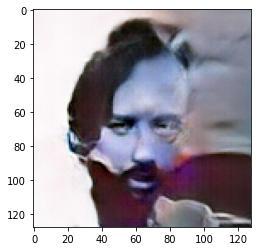

In [ ]:
plt.imshow(test[9])

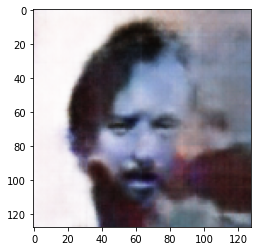

In [ ]:
plt.imshow(decoded_imgs[9])

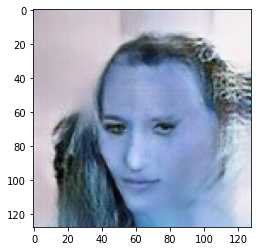

In [ ]:
plt.imshow(test[20])

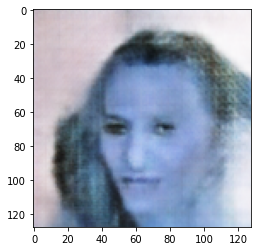

In [ ]:
plt.imshow(decoded_imgs[20])

In [ ]:
predicted_vects = vae_encoder.predict(test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
predicted_vects.shape

(5000, 512)

In [ ]:
with open('dcgan_latent_vectors.npy', 'wb') as f:
    np.save(f, predicted_vects)

In [ ]:
vae_encoder.save('dcgan_encoder.h5')
vae_decoder.save('dcgan_decoder.h5')
vae_model.save('dcgan_model.h5')